In [1]:
import pandas as pd, numpy as np
import tensorflow as tf
import tensorflow_hub as hub, pickle
import tensorflow.keras.backend as K
from pathlib import Path
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import Model
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.layers import Bidirectional, LSTM

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
test = pd.read_csv('final_fewshot_test.csv')
train = pd.read_csv('final_fewshot_train.csv')

In [4]:
train=train[['text','class']]
test=test[['text','class']]

In [5]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/4'
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.load(module_url)

**Siamese Network** 

It is a combination of two CNNs each receiving a separate input to output two encoded vectors, whose distances are differenced to pedict whether the inputs are matching/similar.This network is often paired with the Triplet Loss function.
![Siamese.png](Images/Siamese.png)


In [6]:
input_text1 = Input(shape=(512,))
x = Dense(256, activation='relu')(input_text1)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.4)(x)
dense_layer = Dense(128, name='dense_layer')(x)
norm_layer = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)

model=Model(inputs=[input_text1], outputs=norm_layer)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_layer (Dense)          (None, 128)              

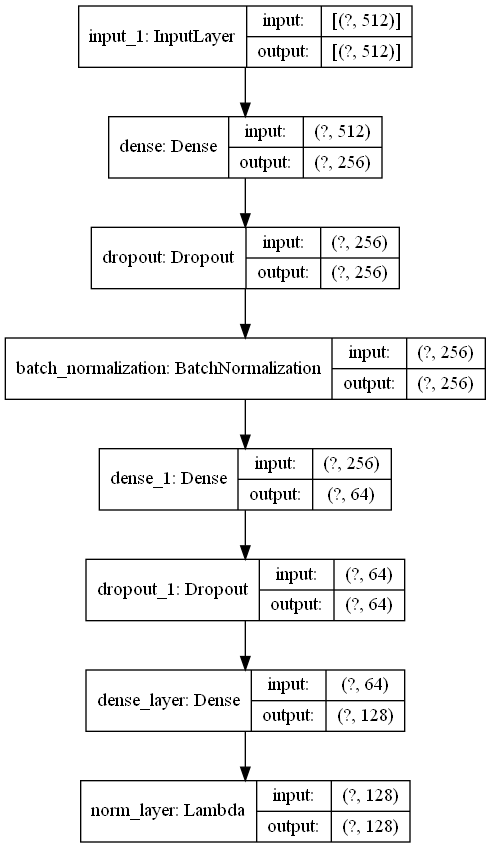

In [7]:
tf.keras.utils.plot_model(model=model,show_shapes=True,show_layer_names=True)

**Triplet Loss Function**

The **Triplet Loss** function is paired with a Siamese network for One/Few shot learning. It takes in 3 inputs i.e. `Anchor(A), Positive(P), Negative(N)` and finds the distance between A&P $||(f(A)-f(P)||^2$ and A&N $||(f(A)-f(N)||^2$. Here `A` is the image/text that you would like to train the model with, `P` the image/text that is most similar/matching to the `A`, `N` the image/text that is different from `A`. It tries to minimise the distance between A&P and maximise the distance between A&N. The loss function is: $||(f(A)-f(P)||^2 - ||(f(A)-f(N)||^2 + \alpha \leq 0$. $\alpha$ is needed here to make sure that the NN does not return 0 as if $||(f(A)-f(P)||^2 - ||(f(A)-f(N)||^2$ are both 0 then result would always satisfy the equation.

![Triplet%20Loss.png](Images/Triplet%20Loss.png) <br>
The cost function **J** is defined as below
![Triplet%20Loss_1.png](Images/Triplet%20Loss_1.png)

In [8]:
# from keras import backend as K
# from keras.models import Model
# from keras.layers import Input, Layer

# Input for anchor, positive and negative images
in_a = Input(shape=(512,))
in_p = Input(shape=(512,))
in_n = Input(shape=(512,))

# Output for anchor, positive and negative embedding vectors
# The nn4_small model instance is shared (Siamese network)
emb_a = model(in_a)
emb_p = model(in_p)
emb_n = model(in_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.4, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

# Model that can be trained with anchor, positive negative images
nn4_small2_train = Model([in_a, in_p, in_n], triplet_loss_layer)

nn4_small2_train.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 128)          157120      input_2[0][0]                    
                                                                 input_3[0][0]         

In [9]:
unique_train_label=np.array(train['class'].unique().tolist())
labels_train=np.array(train['class'].tolist())

map_train_label_indices = {label: np.flatnonzero(labels_train == label) for label in unique_train_label}

In [10]:

#creating the necessary datastructures for selcting triplets
unique_train_label=np.array(train['class'].unique().tolist())
labels_train=np.array(train['class'].tolist())
map_train_label_indices = {label: np.flatnonzero(labels_train == label) for label in unique_train_label}

def get_triplets(unique_train_label,map_train_label_indices):
      label_l, label_r = np.random.choice(unique_train_label, 2, replace=False)
      a, p = np.random.choice(map_train_label_indices[label_l],2, replace=False)
      n = np.random.choice(map_train_label_indices[label_r])
      return a, p, n

def get_triplets_batch(k,train_set,unique_train_label,map_train_label_indices,embed):

    while True:
      idxs_a, idxs_p, idxs_n = [], [], []
      for _ in range(k):
          a, p, n = get_triplets(unique_train_label,map_train_label_indices)
          idxs_a.append(a)
          idxs_p.append(p)
          idxs_n.append(n)

      a=train_set.iloc[idxs_a].values.tolist()
      b=train_set.iloc[idxs_p].values.tolist()
      c=train_set.iloc[idxs_n].values.tolist()

      a = embed(a)
      p = embed(b)
      n = embed(c)
        # return train_set[idxs_a], train_set[idxs_p], train_set[idxs_n]
      yield [a,p,n], []

In [11]:
get_triplets(unique_train_label,map_train_label_indices)

(62, 76, 25)

In [12]:
np.random.choice(unique_train_label, 2, replace=False)

array([4, 5])

In [13]:
np.random.choice(map_train_label_indices[1],2, replace=False)

array([91, 41], dtype=int64)

In [14]:
map_train_label_indices

{1: array([ 0, 13, 19, 24, 29, 34, 38, 40, 41, 45, 46, 54, 56, 68, 82, 84, 87,
        91, 92, 94], dtype=int64),
 3: array([ 1,  4,  7, 16, 20, 22, 31, 43, 47, 49, 50, 51, 52, 53, 64, 65, 70,
        72, 88, 98], dtype=int64),
 4: array([ 2,  5,  9, 12, 15, 18, 21, 25, 26, 32, 35, 37, 42, 48, 59, 61, 66,
        69, 75, 90], dtype=int64),
 2: array([ 3, 10, 11, 17, 23, 30, 57, 62, 67, 74, 76, 77, 79, 80, 81, 85, 86,
        93, 96, 99], dtype=int64),
 5: array([ 6,  8, 14, 27, 28, 33, 36, 39, 44, 55, 58, 60, 63, 71, 73, 78, 83,
        89, 95, 97], dtype=int64)}

In [15]:
# def get_triplets(unique_train_label,map_train_label_indices):
#     label_l, label_r = np.random.choice(unique_train_label, 2, replace=False)
#     a, p = np.random.choice(map_train_label_indices[label_l],2, replace=False)
#     n = np.random.choice(map_train_label_indices[label_r])
#     return a, p, n

# def get_triplets_batch(k,train_set,unique_train_label,map_train_label_indices,embed):
    
#     while True:
#         idxs_a, idxs_p, idxs_n = [], [], []
#         for _ in range(k):
#             a, p, n = get_triplets(unique_train_label,map_train_label_indices)
#             idxs_a.append(a)
#             idxs_p.append(p)
#             idxs_n.append(n)

#             a=train_set.iloc[idxs_a].values.tolist()
#             b=train_set.iloc[idxs_p].values.tolist()
#             c=train_set.iloc[idxs_n].values.tolist()

#             a = embed(a)
#             p = embed(b)
#             n = embed(c)
# # return train_set[idxs_a], train_set[idxs_p], train_set[idxs_n]
#             yield [a,p,n], []

In [16]:
nn4_small2_train.compile(loss=None, optimizer='adam')
nn4_small2_train.fit(get_triplets_batch(128,train['text'],unique_train_label,map_train_label_indices,embed), 
                     epochs=10,steps_per_epoch=10)

Epoch 1/10
10/10 [==============================] - 2s 228ms/step - loss: 44.1471
Epoch 2/10
10/10 [==============================] - 2s 229ms/step - loss: 26.9435
Epoch 3/10
10/10 [==============================] - 2s 225ms/step - loss: 13.7148
Epoch 4/10
10/10 [==============================] - 2s 223ms/step - loss: 7.2389
Epoch 5/10
10/10 [==============================] - 2s 229ms/step - loss: 4.4039
Epoch 6/10
10/10 [==============================] - 2s 225ms/step - loss: 2.6909
Epoch 7/10
10/10 [==============================] - 2s 232ms/step - loss: 1.6348
Epoch 8/10
10/10 [==============================] - 2s 231ms/step - loss: 1.2188
Epoch 9/10
10/10 [==============================] - 2s 230ms/step - loss: 1.0138
Epoch 10/10
10/10 [==============================] - 2s 227ms/step - loss: 0.9436


In [17]:
embed(np.array(train['text'].values.tolist())).values()

dict_values([<tf.Tensor: shape=(100, 512), dtype=float32, numpy=
array([[ 0.00675378,  0.04573042,  0.04617406, ..., -0.02799173,
        -0.02848471,  0.0246704 ],
       [-0.01076334,  0.0537428 ,  0.05575569, ...,  0.06669761,
        -0.06215806,  0.04347511],
       [ 0.04188274,  0.03026657,  0.07034004, ...,  0.04839662,
        -0.01818151,  0.04325569],
       ...,
       [-0.01506545, -0.01263892,  0.0147373 , ...,  0.05511449,
         0.00967759, -0.06263431],
       [ 0.01497612,  0.01398005,  0.05304173, ...,  0.06690799,
         0.00087237, -0.0693117 ],
       [-0.01732653,  0.01941372,  0.06741212, ...,  0.10908649,
        -0.03401837, -0.04340868]], dtype=float32)>])

In [18]:
input_text1

<tf.Tensor 'input_1:0' shape=(None, 512) dtype=float32>

In [20]:
X_train_embed = embed(np.array(train['text'].values.tolist()))

In [21]:
X_train_embed['outputs'].shape

TensorShape([100, 512])

In [24]:
# test['text'][:1000]

0      ApiServer: Fix apidiscovery fail case, fix com...
1      [GSCOLLECT-1606] Improve primitive map perform...
2            Big rename and more pointcut features in UI
3      Network-refactor: fix bugs in components.xml d...
4      HADOOP-10659. Refactor AccessControlList to re...
                             ...                        
995    Clean up (and improve performance of) the crea...
996    ACT-675 + ACT-673 added historicTaskInstanceQu...
997    attempting to fix the performance problem in a...
998    Created an HTML help system, which is hooked u...
999    Improved readability for /whitelist list. Addr...
Name: text, Length: 1000, dtype: object

In [25]:
X_test_embed = embed(np.array(test['text'][:1000].values.tolist()))

In [32]:
X_train = model.predict(X_train_embed)
X_test = model.predict(X_test_embed)

y_train = np.array(train['class'].values.tolist())
y_test = np.array(test['class'][:1000].values.tolist())

In [33]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
y_pred_svc = svc.predict(X_test)
acc_svc = accuracy_score(y_test, y_pred_svc)

print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

KNN accuracy = 0.887, SVM accuracy = 0.883


In [34]:
from sklearn import metrics
print(metrics.classification_report(list(y_test), list(y_pred_knn)))

              precision    recall  f1-score   support

           1       0.93      0.91      0.92       329
           2       0.60      0.91      0.72        68
           3       0.97      0.79      0.87       137
           4       0.88      0.86      0.87       180
           5       0.92      0.92      0.92       286

    accuracy                           0.89      1000
   macro avg       0.86      0.88      0.86      1000
weighted avg       0.90      0.89      0.89      1000



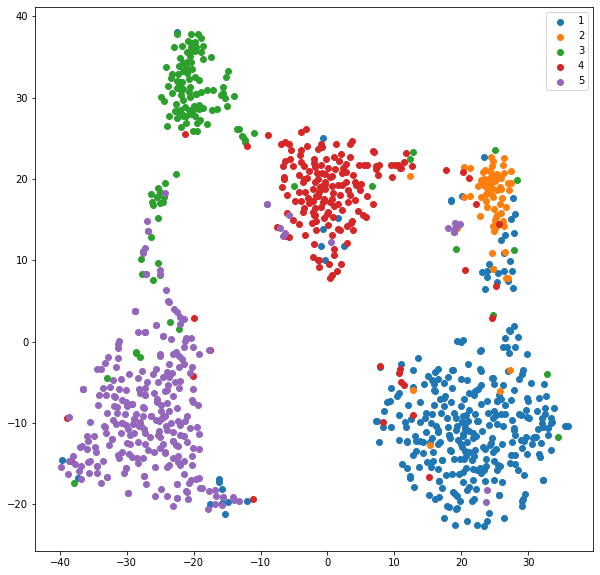

In [37]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X_embedded = TSNE(n_components=2).fit_transform(X_test)

plt.figure(figsize=(10,10))

for i, t in enumerate(set(y_test)):
    idx = y_test == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));

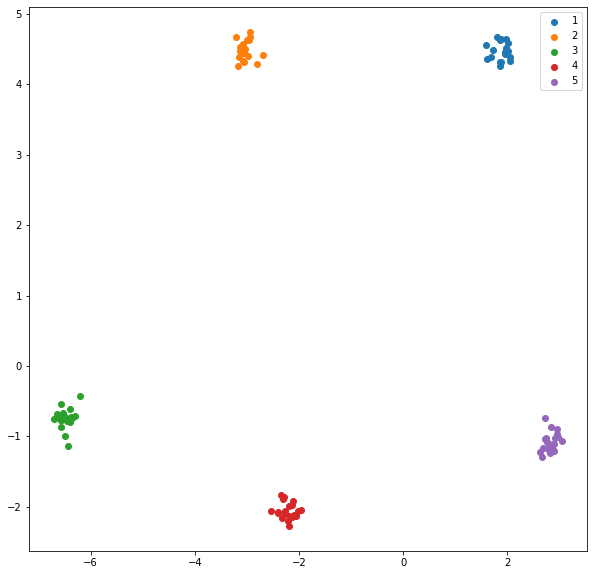

In [38]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(X_train)

plt.figure(figsize=(10,10))

for i, t in enumerate(set(y_train)):
    idx = y_train == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));